# Perturbed-Attention Guidance (Stable Diffusion Demo)

This is a demo for Perturbed-Attention Guidance (PAG) on Stable Diffusion. Perturbed-Attention Guidance significantly improves sample quality in unconditional and conditional generation, without additional training or external conditions. It can be easily used with any kinds of diffusion models. For more information, Please refer to the paper published in arXiv for additional information. (https://arxiv.org/abs/2403.17377)

In [ ]:
!pip install -q diffusers transformers accelerate opencv-python

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 13.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 290.1/290.1 kB 20.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 23.7/23.7 MB 47.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 823.6/823.6 kB 48.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 14.1/14.1 MB 71.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 731.7/731.7 MB 1.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 410.6/410.6 MB 3.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 121.6/121.6 MB 8.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.5/56.5 MB 11.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 124.2/124.2 MB 8.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 196.0/196.0 MB 6.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 166.0/166.0 MB 7.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━

In [ ]:
import numpy as np
import torch
import cv2

from diffusers import StableDiffusionPipeline
from diffusers.utils.torch_utils import randn_tensor

from accelerate.utils import set_seed
from google.colab.patches import cv2_imshow

The cache for model files in Transformers v4.22.0 has been updated. Migrating your old cache. This is a one-time only operation. You can interrupt this and resume the migration later on by calling `transformers.utils.move_cache()`.


0it [00:00, ?it/s]

In [ ]:
# load pipeline

pipe = StableDiffusionPipeline.from_pretrained(
    "runwayml/stable-diffusion-v1-5",
    custom_pipeline="hyoungwoncho/sd_perturbed_attention_guidance",
    torch_dtype=torch.float16
)

device="cuda"
pipe = pipe.to(device)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:88: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


model_index.json:   0%|          | 0.00/541 [00:00<?, ?B/s]

pipeline.py:   0%|          | 0.00/73.5k [00:00<?, ?B/s]

Fetching 15 files:   0%|          | 0/15 [00:00<?, ?it/s]

model.safetensors:   0%|          | 0.00/492M [00:00<?, ?B/s]

safety_checker/config.json:   0%|          | 0.00/4.72k [00:00<?, ?B/s]

tokenizer/merges.txt:   0%|          | 0.00/525k [00:00<?, ?B/s]

tokenizer/special_tokens_map.json:   0%|          | 0.00/472 [00:00<?, ?B/s]

scheduler/scheduler_config.json:   0%|          | 0.00/308 [00:00<?, ?B/s]

text_encoder/config.json:   0%|          | 0.00/617 [00:00<?, ?B/s]

(…)ature_extractor/preprocessor_config.json:   0%|          | 0.00/342 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/1.22G [00:00<?, ?B/s]

tokenizer/tokenizer_config.json:   0%|          | 0.00/806 [00:00<?, ?B/s]

tokenizer/vocab.json:   0%|          | 0.00/1.06M [00:00<?, ?B/s]

unet/config.json:   0%|          | 0.00/743 [00:00<?, ?B/s]

vae/config.json:   0%|          | 0.00/547 [00:00<?, ?B/s]

diffusion_pytorch_model.safetensors:   0%|          | 0.00/3.44G [00:00<?, ?B/s]

diffusion_pytorch_model.safetensors:   0%|          | 0.00/335M [00:00<?, ?B/s]

Loading pipeline components...:   0%|          | 0/7 [00:00<?, ?it/s]

## Uncondtional Generation

In [93]:
# hyperparameters

pag_scale = 5.0
pag_applied_layers_index = ['m0']

seed = 321

In [94]:
# sampling

set_seed(seed)
latent_input = randn_tensor(shape=(1,4,64,64),generator=None, device=device, dtype=torch.float16)

output_baseline = pipe(
    "",
    width=512,
    height=512,
    num_inference_steps=50,
    guidance_scale=0.0,
    pag_scale=0.0,
    pag_applied_layers_index=pag_applied_layers_index,
    latents=latent_input
).images[0]
output_baseline.save(f'uncond_baseline.png')

output_pag = pipe(
    "",
    width=512,
    height=512,
    num_inference_steps=50,
    guidance_scale=0.0,
    pag_scale=pag_scale,
    pag_applied_layers_index=pag_applied_layers_index,
    latents=latent_input
).images[0]
output_pag.save(f'uncond_pag.png')

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

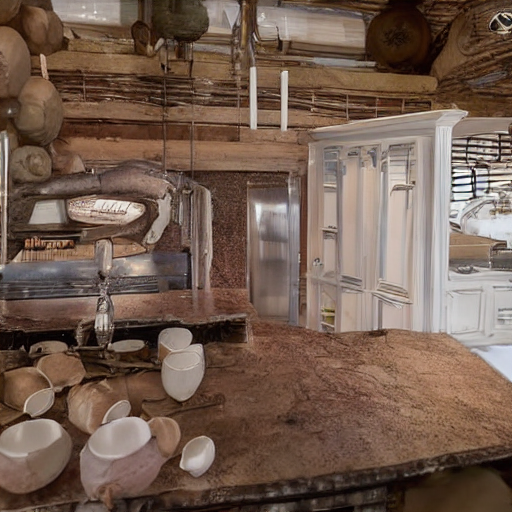

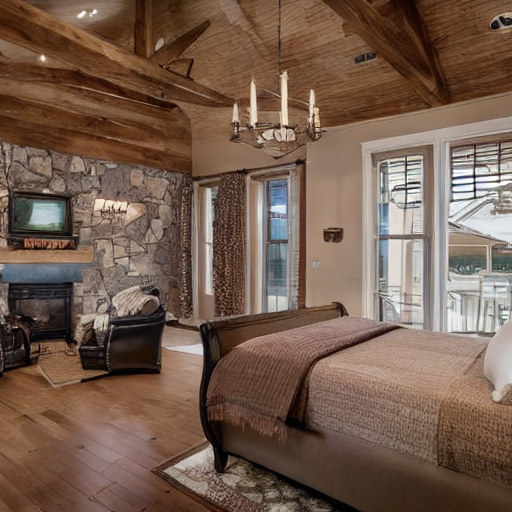

In [108]:
uncond_baseline = cv2.imread('uncond_baseline.png')
uncond_pag = cv2.imread('uncond_pag.png')

cv2_imshow(uncond_baseline)
print()
cv2_imshow(uncond_pag)

## Text-to-Image Synthesis

In [139]:
# hyperparameters

pag_scale = 5.0
pag_applied_layers_index = ['m0']

prompt = "a cute corgi"

seed = 7777

In [140]:
# sampling

set_seed(seed)
latent_input = randn_tensor(shape=(1,4,64,64),generator=None, device=device, dtype=torch.float16)

output_baseline = pipe(
    prompt,
    width=512,
    height=512,
    num_inference_steps=50,
    guidance_scale=1.0,
    pag_scale=0.0,
    pag_applied_layers_index=pag_applied_layers_index,
    latents=latent_input
).images[0]
output_baseline.save(f'cond_baseline.png')

output_pag = pipe(
    prompt,
    width=512,
    height=512,
    num_inference_steps=50,
    guidance_scale=0.0,
    pag_scale=pag_scale,
    pag_applied_layers_index=pag_applied_layers_index,
    latents=latent_input
).images[0]
output_pag.save(f'cond_pag.png')

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

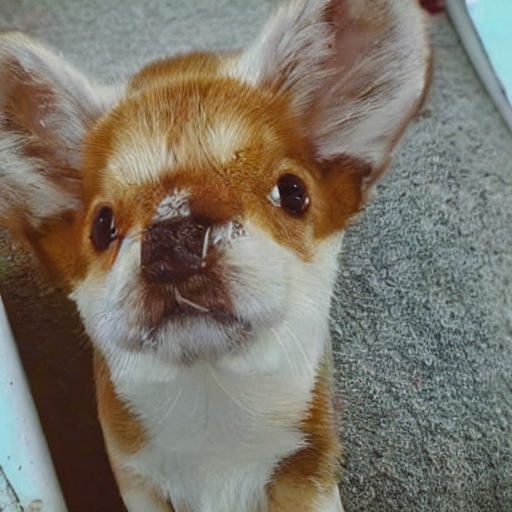

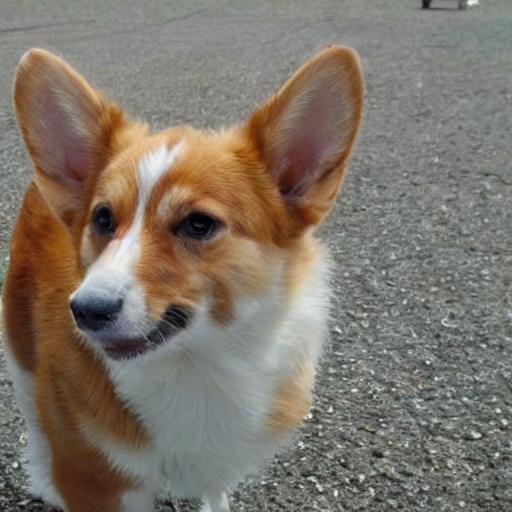

In [141]:
uncond_baseline = cv2.imread('cond_baseline.png')
uncond_pag = cv2.imread('cond_pag.png')

cv2_imshow(uncond_baseline)
print()
cv2_imshow(uncond_pag)